In [25]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from process_tiffs import save_masked_tiff, extract_classification_info, plot_tiff_with_classes, plot_time_series, create_time_series, calcular_media_temperatura, combinar_datasets, criar_dataset_completo

In [26]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [27]:
path = '../dados/estacoes'  
all_files = glob.glob(path + "/*.csv")  

all_data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_data.append(df)

combined_data = pd.concat(all_data, axis=0, ignore_index=True)
combined_data.head()

,mes,hora,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,temperatura_bulbo_hora,temperatura_orvalho_hora,temperatura_orvalho_max,...,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade,temperatura_min,data,id_estacao,ano,temperatura_max
0,5,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.184187,2003-05-26,A412,2003,31.006134
1,5,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.423990,2003-05-27,A412,2003,31.069967
2,5,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.347433,2003-05-27,A412,2003,31.033491
3,5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.179983,2003-05-28,A412,2003,31.019276
4,5,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.190351,2003-05-29,A412,2003,30.994087


In [6]:
combined_data.columns

Index(['mes', 'hora', 'precipitacao_total', 'pressao_atm_hora',
       'pressao_atm_max', 'pressao_atm_min', 'radiacao_global',
       'temperatura_bulbo_hora', 'temperatura_orvalho_hora',
       'temperatura_orvalho_max', 'temperatura_orvalho_min', 'umidade_rel_max',
       'umidade_rel_min', 'umidade_rel_hora', 'vento_direcao',
       'vento_rajada_max', 'vento_velocidade', 'temperatura_min', 'data',
       'id_estacao', 'ano', 'temperatura_max'],
      dtype='object')

In [7]:
# Abrir o shapefile de estações
gdf_voronoi = gpd.read_file(('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp'))
gdf_voronoi.head()

,id_estacao,latitude,longitude,geometry
0,A336,-8.441667,-43.865556,"MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ..."
1,A365,-8.117939,-42.975721,"MULTIPOLYGON (((-43.28134 -8.66269, -43.63515 ..."
2,A416,-13.332500,-44.617500,"MULTIPOLYGON (((-44.05675 -12.61621, -44.05717..."
3,A433,-14.181944,-41.672222,"POLYGON ((-42.21703 -13.71785, -42.21693 -13.7..."
4,A308,-3.086667,-41.783056,"POLYGON ((-41.52190 -3.55804, -41.52253 -3.558..."


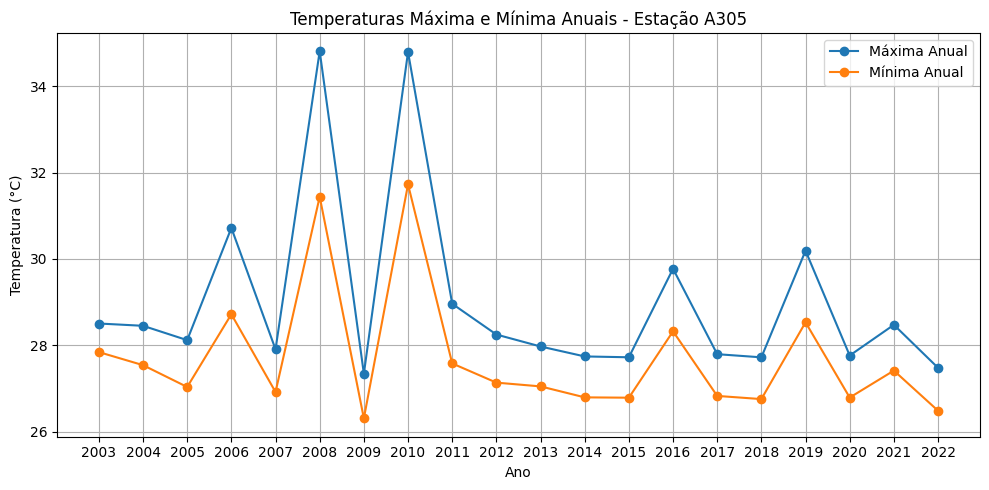

In [8]:
# Filtrar os dados apenas para a estação A305
dados_A305 = combined_data[combined_data['id_estacao'] == 'A305']

# Agrupar por ano e calcular a temperatura máxima e mínima anual
temperatura_anual = dados_A305.groupby('ano').agg(
    temperatura_max=('temperatura_max', 'mean'),
    temperatura_min=('temperatura_min', 'mean')
).reset_index()

# Plotar a série temporal anual
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima Anual', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima Anual', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais - Estação A305')
plt.xticks(range(temperatura_anual['ano'].min(), temperatura_anual['ano'].max() + 1))  # Define os ticks do eixo x para cada ano
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

In [9]:
# Criar um dataframe com o ano, o id_estacao e as médias anuais de temperatura_max e temperatura_min
df_temperatura_anual = combined_data.groupby(['ano', 'id_estacao']).agg(
    temperatura_max_media=('temperatura_max', 'mean'),
    temperatura_min_media=('temperatura_min', 'mean')
).reset_index()

df_temperatura_anual.head()

,ano,id_estacao,temperatura_max_media,temperatura_min_media
0,2003,A305,28.503954,27.842044
1,2003,A306,29.013431,27.881295
2,2003,A307,27.557800,26.406916
3,2003,A308,28.705627,27.938045
4,2003,A408,25.966612,24.724959


In [10]:
# arredondar a temperatura máxima e mínima para 1 casa decimal
df_temperatura_anual['temperatura_max_media'] = df_temperatura_anual['temperatura_max_media'].round(1)
df_temperatura_anual['temperatura_min_media'] = df_temperatura_anual['temperatura_min_media'].round(1)

# Transformar ponto em virgula
df_temperatura_anual['temperatura_max_media'] = df_temperatura_anual['temperatura_max_media'].apply(lambda x: str(x).replace('.', ','))
df_temperatura_anual['temperatura_min_media'] = df_temperatura_anual['temperatura_min_media'].apply(lambda x: str(x).replace('.', ','))

In [11]:
df_temperatura_anual.head()

,ano,id_estacao,temperatura_max_media,temperatura_min_media
0,2003,A305,"28,5","27,8"
1,2003,A306,"29,0","27,9"
2,2003,A307,"27,6","26,4"
3,2003,A308,"28,7","27,9"
4,2003,A408,"26,0","24,7"


In [12]:
# salvar como um arquivo CSV
df_temperatura_anual.to_csv('../dados/dataset_temperatura.csv', index=False)

# Temperaturas

In [13]:
# Calcular o aumento da temperatura
temp_increase = combined_data.groupby('id_estacao').apply(lambda x: x[x['ano'] == x['ano'].max()]['temperatura_max'].mean() - x[x['ano'] == x['ano'].min()]['temperatura_max'].mean())
temp_increase = temp_increase.reset_index()
temp_increase.columns = ['id_estacao', 'temp_increase']

# Verificar se a coluna 'id_estacao' existe no GeoDataFrame
if 'id_estacao' in gdf_voronoi.columns:
    # Adicionar a coluna 'temp_increase' ao GeoDataFrame
    gdf_voronoi_temp = gdf_voronoi.merge(temp_increase, on='id_estacao', how='left')

temp_increase.head()

,id_estacao,temp_increase
0,A305,-1.026185
1,A306,5.163382
2,A307,2.486618
3,A308,0.431849
4,A309,0.203919


In [14]:
# arredondar para 1 casa decimal
temp_increase = temp_increase.round(1)

# Transformar ponto em virgula
temp_increase['temp_increase'] = temp_increase['temp_increase'].apply(lambda x: str(x).replace('.', ','))

In [15]:
temp_increase.head()

,id_estacao,temp_increase
0,A305,"-1,0"
1,A306,"5,2"
2,A307,"2,5"
3,A308,"0,4"
4,A309,"0,2"


In [16]:
# salvar como um arquivo CSV
temp_increase.to_csv('../dados/dataset_mudanca_temperatura_max.csv', index=False)

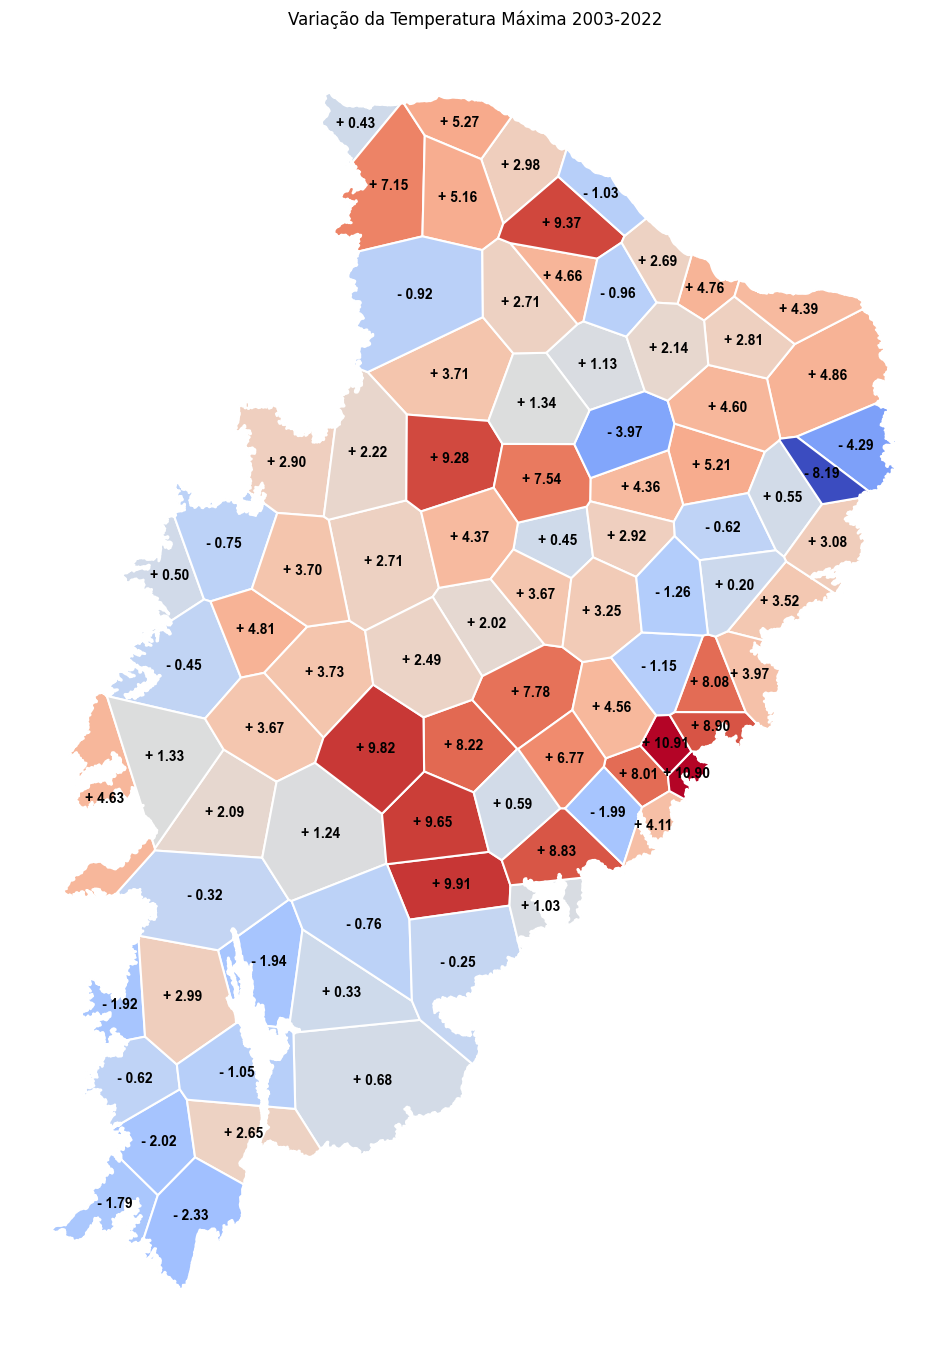

In [17]:
# Visualizar o mapa com bordas mais grossas e adicionar + ou - com a temperatura
fig, ax = plt.subplots(1, 1, figsize=(12, 24))

# Adicionando espessura às bordas das regiões
gdf_voronoi_temp.plot(column='temp_increase', ax=ax, cmap='coolwarm', edgecolor='white', linewidth=1.5)

# Adicionar + e - com a temperatura em cada região
for idx, row in gdf_voronoi_temp.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    temp_change = row['temp_increase']
    symbol = '+ ' if temp_change > 0 else '- '
    ax.text(x, y, f"{symbol}{abs(temp_change):.2f}", ha='center', va='center', fontsize=10, fontname='Arial', fontweight='bold', color='black')

# Remover bordas externas do plot
ax.set_axis_off()
ax.set_title('Variação da Temperatura Máxima 2003-2022')
plt.show()

In [18]:
# Determinar o ano
ano = 2022

# Filtrar os dados para o ano
dados_ano_recente = combined_data[combined_data['ano'] == ano]

# Filtrar os dados para janeiro e dezembro do ano mais recente
inicio_do_ano = dados_ano_recente[dados_ano_recente['mes'] == 1]
final_do_ano = dados_ano_recente[dados_ano_recente['mes'] == 12]

# Calcular a diferença de temperatura para cada estação entre janeiro e dezembro
temp_increase = inicio_do_ano.groupby('id_estacao')['temperatura_max'].mean() - final_do_ano.groupby('id_estacao')['temperatura_max'].mean()
temp_increase = temp_increase.reset_index()
temp_increase.columns = ['id_estacao', 'temp_increase']

# Verificar se a coluna 'id_estacao' existe no GeoDataFrame
if 'id_estacao' in gdf_voronoi.columns:
    # Adicionar a coluna 'temp_increase' ao GeoDataFrame
    gdf_voronoi_temp = gdf_voronoi.merge(temp_increase, on='id_estacao', how='left')


temp_increase.head()

,id_estacao,temp_increase
0,A305,-1.051852
1,A306,5.727757
2,A307,-8.086257
3,A308,2.942900
4,A309,9.950970


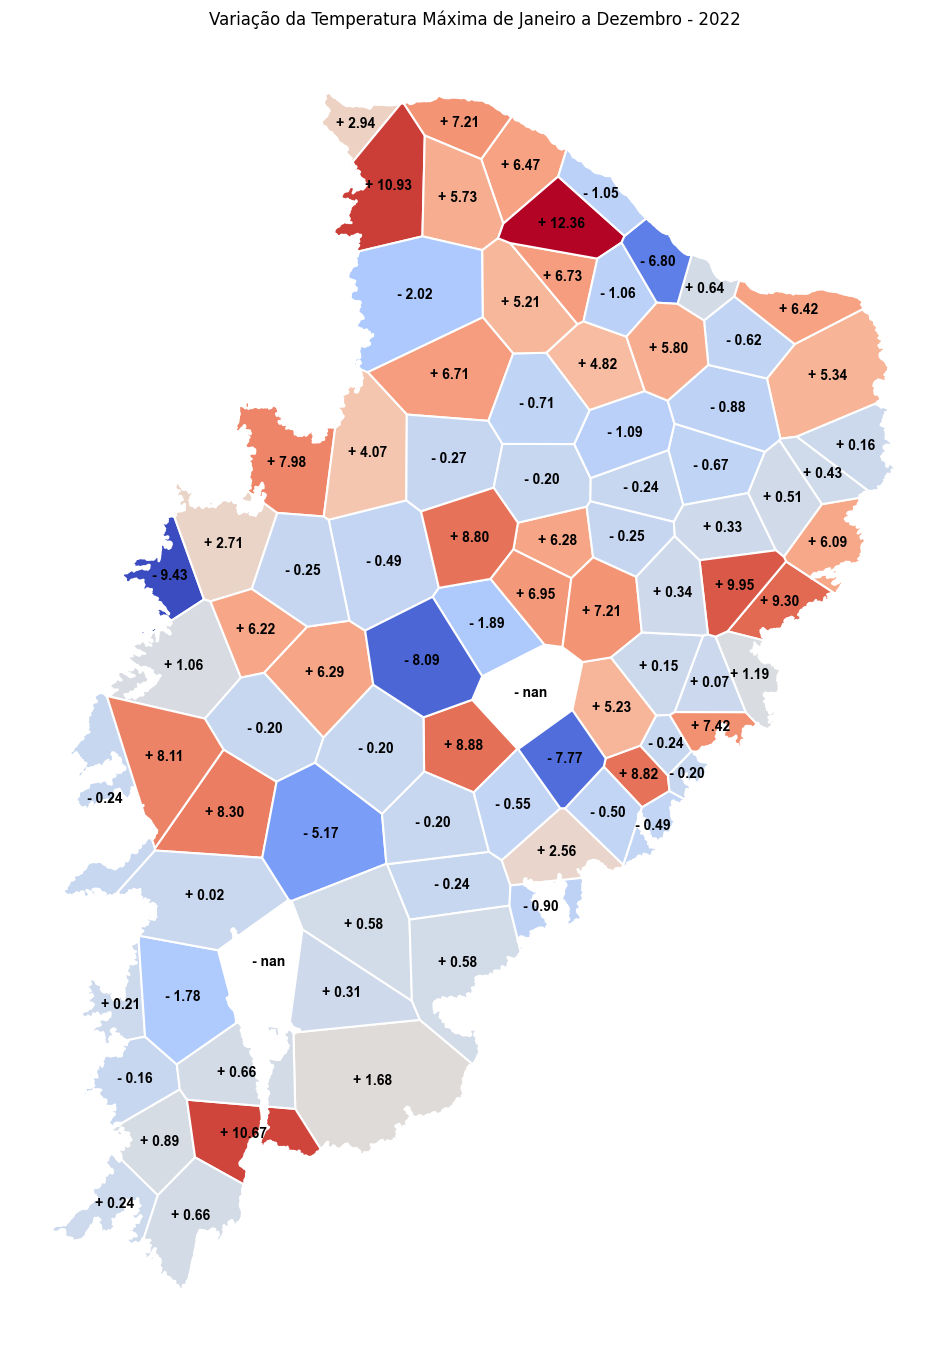

In [19]:
# Visualizar o mapa com bordas mais grossas e adicionar + ou - com a temperatura
fig, ax = plt.subplots(1, 1, figsize=(12, 24))

# Adicionando espessura às bordas das regiões
gdf_voronoi_temp.plot(column='temp_increase', ax=ax, cmap='coolwarm', edgecolor='white', linewidth=1.5)

# Adicionar + e - com a temperatura em cada região
for idx, row in gdf_voronoi_temp.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    temp_change = row['temp_increase']
    symbol = '+ ' if temp_change > 0 else '- '
    ax.text(x, y, f"{symbol}{abs(temp_change):.2f}", ha='center', va='center', fontsize=10, fontname='Arial', fontweight='bold', color='black')

# Remover bordas externas do plot
ax.set_axis_off()
ax.set_title(f'Variação da Temperatura Máxima de Janeiro a Dezembro - {ano}')
plt.show()

In [28]:
# Calcular o aumento da temperatura
temp_increase = combined_data.groupby('id_estacao').apply(lambda x: x[x['ano'] == x['ano'].max()]['temperatura_min'].mean() - x[x['ano'] == x['ano'].min()]['temperatura_min'].mean())
temp_increase = temp_increase.reset_index()
temp_increase.columns = ['id_estacao', 'temp_increase']

# Verificar se a coluna 'id_estacao' existe no GeoDataFrame
if 'id_estacao' in gdf_voronoi.columns:
    # Adicionar a coluna 'temp_increase' ao GeoDataFrame
    gdf_voronoi_temp = gdf_voronoi.merge(temp_increase, on='id_estacao', how='left')

temp_increase.head()

,id_estacao,temp_increase
0,A305,-1.357779
1,A306,2.538438
2,A307,1.381688
3,A308,-0.655183
4,A309,-1.720052


In [29]:
# arredondar para 1 casa decimal
temp_increase = temp_increase.round(1)

# Transformar ponto em virgula
temp_increase['temp_increase'] = temp_increase['temp_increase'].apply(lambda x: str(x).replace('.', ','))
temp_increase.head()

,id_estacao,temp_increase
0,A305,"-1,4"
1,A306,"2,5"
2,A307,"1,4"
3,A308,"-0,7"
4,A309,"-1,7"


In [30]:
# salvar como um arquivo CSV
temp_increase.to_csv('../dados/dataset_mudanca_temperatura_min.csv', index=False)

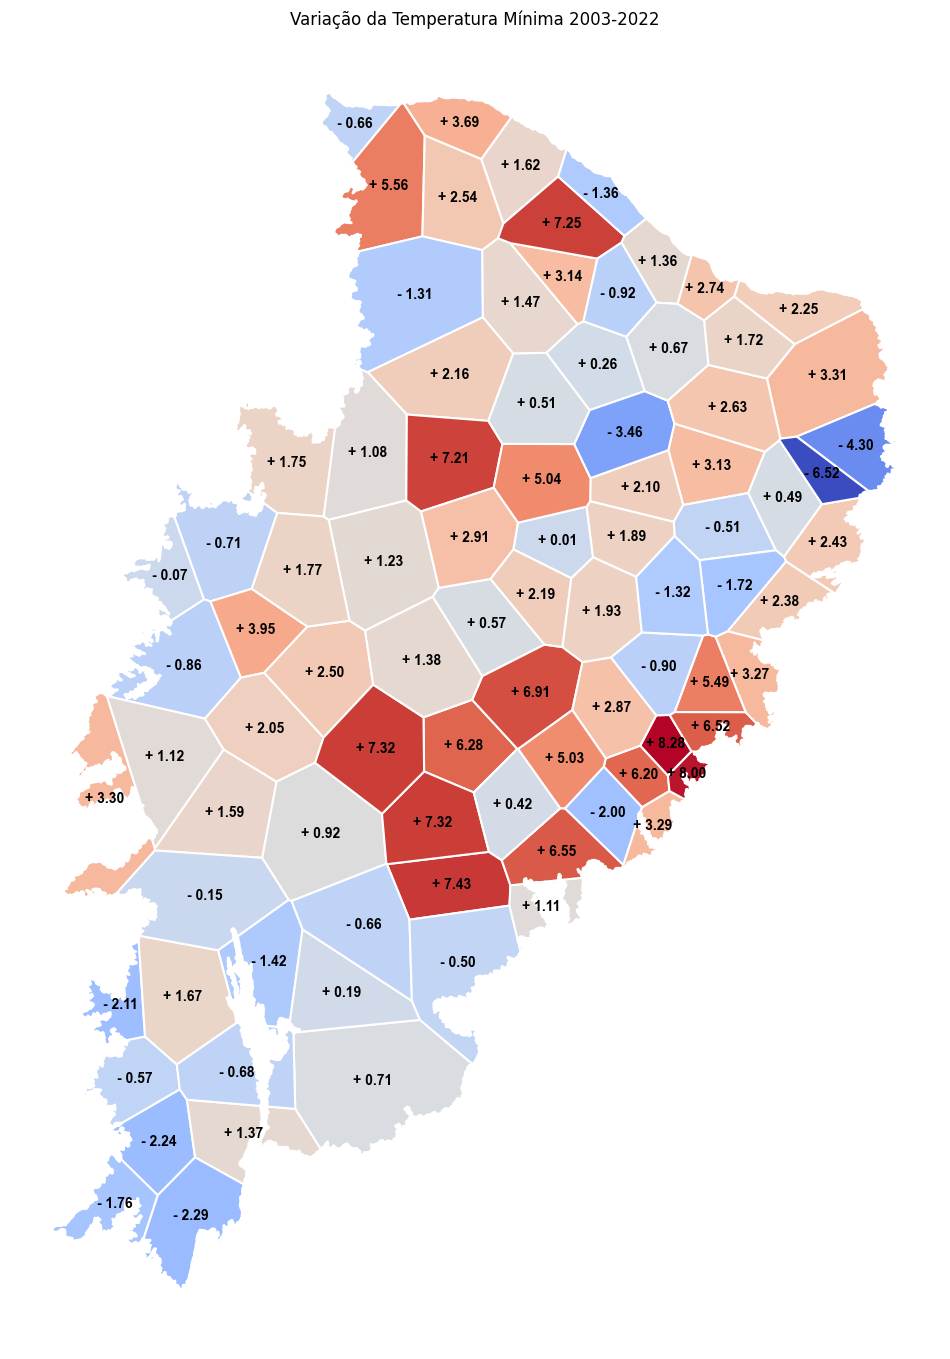

In [31]:
# Visualizar o mapa com bordas mais grossas e adicionar + ou - com a temperatura
fig, ax = plt.subplots(1, 1, figsize=(12, 24))

# Adicionando espessura às bordas das regiões
gdf_voronoi_temp.plot(column='temp_increase', ax=ax, cmap='coolwarm', edgecolor='white', linewidth=1.5)

# Adicionar + e - com a temperatura em cada região
for idx, row in gdf_voronoi_temp.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    temp_change = row['temp_increase']
    symbol = '+ ' if temp_change > 0 else '- '
    ax.text(x, y, f"{symbol}{abs(temp_change):.2f}", ha='center', va='center', fontsize=10, fontname='Arial', fontweight='bold', color='black')

# Remover bordas externas do plot
ax.set_axis_off()
ax.set_title('Variação da Temperatura Mínima 2003-2022')
plt.show()

# Classes

In [55]:
# Lista para armazenar os DataFrames de cada estação
datasets_completos = []
output_base_dir = '../dados/raster_tiff_caating'
start_year = 2003
end_year = 2022

# Iterar sobre cada estação e criar o dataset completo
for estacao_id in gdf_voronoi['id_estacao']:
    # Criar o dataset completo para a estação atual
    dataset_completo = criar_dataset_completo(combined_data, output_base_dir, estacao_id, start_year, end_year)
    
    # Adicionar o ID da estação ao DataFrame
    dataset_completo['id_estacao'] = estacao_id
    
    # Verificar e preencher os anos ausentes
    anos_presentes = set(dataset_completo['ano'])
    anos_faltantes = set(range(start_year, end_year + 1)) - anos_presentes
    
    for ano in anos_faltantes:
        # Criar o caminho para o arquivo TIFF faltante
        tiff_path = os.path.join(output_base_dir, str(ano), f'coverage_{estacao_id}_{ano}.tif')
        
        if os.path.exists(tiff_path):
            sorted_class_counts = extract_classification_info(tiff_path)
            # Remover a entrada com ID de classe 0, se existir
            if 0 in sorted_class_counts:
                del sorted_class_counts[0]
            # Criar um dicionário com os dados do ano faltante
            dados_ano_faltante = {
                'ano': ano,
                'temperatura_max': 0,
                'temperatura_min': 0,
                'id_estacao': estacao_id
            }
            # Adicionar as contagens de superpixels ao dicionário
            dados_ano_faltante.update(sorted_class_counts)
            
            # Converter o dicionário em um DataFrame de uma linha e adicionar ao dataset
            df_ano_faltante = pd.DataFrame([dados_ano_faltante])
            dataset_completo = pd.concat([dataset_completo, df_ano_faltante], ignore_index=True)
        else:
            print(f"Arquivo {tiff_path} não encontrado.")
    
    # Adicionar o dataset da estação à lista
    datasets_completos.append(dataset_completo)

# Concatenar todos os DataFrames em um único DataFrame
dataset_completo_todas_estacoes = pd.concat(datasets_completos, ignore_index=True)

# Substituir valores NaN por 0
dataset_completo_todas_estacoes.fillna(0, inplace=True)

# Ordenar o DataFrame por id_estacao e ano
dataset_completo_todas_estacoes = dataset_completo_todas_estacoes.sort_values(by=['id_estacao', 'ano']).reset_index(drop=True)

# Exibir as primeiras linhas do DataFrame final atualizado
dataset_completo_todas_estacoes.head()

# salvar dataset_completo_todas_estacoes como um arquivo CSV
dataset_completo_todas_estacoes.to_csv('../dados/dataset_completo_todas_estacoes.csv', index=False)

In [56]:
dataset_completo_todas_estacoes = pd.read_csv('../dados/dataset_completo_todas_estacoes.csv')

In [57]:
id_to_class_name = {
    1: "Formação Florestal",
    3: "Formação Florestal",
    4: "Formação Savânica",
    5: "Mangue",
    6: "Floresta Alagável",
    49: "Restinga Arbórea",
    11: "Campo Alagado e Área Pantanosa",
    12: "Formação Campestre ",
    32: "Apicum",
    29: "Afloramento Rochoso",
    50: "Restinga Herbácea",
    13: "Outras Formações Não Florestais",
    14: "Agropecuária",
    15: "Pastagem",
    18: "Agricultura",
    19: "Lavoura Temporária",
    39: "Soja",
    20: "Cana",
    40: "Arroz",
    62: "Algodão (beta)",
    41: "Outras Lavouras Temporárias",
    36: "Lavoura Perene",
    21: "Mosaico de Usos",
    46: "Café",
    47: "Citros",
    35: "Dendê (beta)",
    48: "Outras Lavouras Perenes",
    9: "Silvicultura",
    23: "Praia, Duna e Areal",
    24: "Área Urbanizada",
    30: "Mineração",
    25: "Outras Áreas não Vegetadas",
    33: "Rio, Lago e Oceano ",
    31: "Aquicultura",
    27: "Não Observado",
    26: "Corpo d'água",
    22: "Área não Vegetada",
    10: "Formação Natural não Florestal",
    0: "Não Classificado",

}

class_colors = {
        1: "#32a65e", 6: "#026975", 10: "#ad975a", 13: "#d89f5c", 14: "#FFFFB2", 
        18: "#E974ED", 19: "#C27BA0", 40: "#c71585", 36: "#d082de", 46: "#d68fe2", 
        3: "#1f8d49", 4: "#7dc975", 5: "#04381d", 49: "#02d659", 20: "#db7093",
        11: "#519799", 12: "#d6bc74", 32: "#fc8114", 29: "#ffaa5f", 50: "#ad5100",
        15: "#edde8e", 39: "#f5b3c8", 62: "#ff69b4", 41: "#f54ca9", 46: "#d68fe2",
        48: "#e6ccff", 9: "#7a5900", 21: "#ffefc3", 23: "#ffa07a", 24: "#d4271e", 
        30: "#9c0027", 25: "#db4d4f", 33: "#2532e4", 31: "#091077", 0: "#FFFFFF", 
        27: "#FFFFFF", 35:"#9065d0", 22: "#d4271e", 26: "#0000FF"
    }

In [59]:
# Criar uma cópia do dataset para não modificar o original
dataset_completo_mapeado = dataset_completo_todas_estacoes.copy()

# Substituir os IDs das colunas pelos nomes das classes, garantindo que as chaves sejam tratadas como strings
new_column_names = {
    str(col): id_to_class_name[int(col)] for col in dataset_completo_todas_estacoes.columns if col.isdigit() and int(col) in id_to_class_name
}

# Renomear as colunas do dataset
dataset_completo_mapeado.rename(columns=new_column_names, inplace=True)

# Verificar o novo dataset
dataset_completo_mapeado.head()

,ano,temperatura_max,temperatura_min,Soja,"Rio, Lago e Oceano",Outras Lavouras Temporárias,Área Urbanizada,Outras Áreas não Vegetadas,Pastagem,Formação Campestre,...,Outras Lavouras Perenes,Mineração,Aquicultura,Apicum,Mangue,"Praia, Duna e Areal",Cana,Outras Formações Não Florestais,Restinga Arbórea,Restinga Herbácea
0,2003,33.40000,21.4,0.0,253628.0,34098.0,451289.0,47489.0,120126.0,66877.0,...,149318.0,0.0,2574.0,4683.0,24970.0,140382.0,0.0,0.0,0.0,0.0
1,2004,33.20000,21.7,0.0,263979.0,35944.0,459531.0,40349.0,132801.0,64771.0,...,165220.0,0.0,2761.0,4410.0,25162.0,137925.0,0.0,0.0,0.0,0.0
2,2005,33.70000,21.1,0.0,244677.0,42089.0,466019.0,34459.0,155191.0,65402.0,...,206048.0,0.0,3344.0,4303.0,25392.0,134406.0,0.0,0.0,0.0,0.0
3,2006,33.93924,20.4,0.0,241594.0,50899.0,470223.0,34696.0,168667.0,64630.0,...,228522.0,0.0,3677.0,4081.0,25559.0,131636.0,0.0,0.0,0.0,0.0
4,2007,34.00000,21.3,0.0,241064.0,54823.0,474057.0,34702.0,189931.0,61626.0,...,256069.0,0.0,3748.0,3909.0,25426.0,130868.0,0.0,0.0,0.0,0.0


In [71]:
# remover as colunas de temperatura máxima e mínima
dataset_completo_mapeado.drop(columns=['temperatura_max', 'temperatura_min'], inplace=True)

In [63]:
# Transformar as classes em inteiro
for col in new_column_names.values():
    dataset_completo_mapeado[col] = dataset_completo_mapeado[col].astype(int)

In [72]:
dataset_completo_mapeado.head()

,ano,Soja,"Rio, Lago e Oceano",Outras Lavouras Temporárias,Área Urbanizada,Outras Áreas não Vegetadas,Pastagem,Formação Campestre,Mosaico de Usos,Formação Florestal,...,Outras Lavouras Perenes,Mineração,Aquicultura,Apicum,Mangue,"Praia, Duna e Areal",Cana,Outras Formações Não Florestais,Restinga Arbórea,Restinga Herbácea
0,2003,0,253628,34098,451289,47489,120126,66877,884053,1874707,...,149318,0,2574,4683,24970,140382,0,0,0,0
1,2004,0,263979,35944,459531,40349,132801,64771,886343,1801735,...,165220,0,2761,4410,25162,137925,0,0,0,0
2,2005,0,244677,42089,466019,34459,155191,65402,833253,1767177,...,206048,0,3344,4303,25392,134406,0,0,0,0
3,2006,0,241594,50899,470223,34696,168667,64630,818379,1753663,...,228522,0,3677,4081,25559,131636,0,0,0,0
4,2007,0,241064,54823,474057,34702,189931,61626,794502,1706385,...,256069,0,3748,3909,25426,130868,0,0,0,0


In [ ]:
# salvar dataset_completo_mapeado como um arquivo CSV
dataset_completo_mapeado.to_csv('../dados/dataset_completo_mapeado.csv', index=False)

In [3]:
dataset_completo_mapeado = pd.read_csv('../dados/dataset_completo_mapeado.csv')
dataset_completo_mapeado[dataset_completo_mapeado['id_estacao'] == 'A305']

,ano,Soja,"Rio, Lago e Oceano",Outras Lavouras Temporárias,Área Urbanizada,Outras Áreas não Vegetadas,Pastagem,Formação Campestre,Mosaico de Usos,Formação Florestal,...,Outras Lavouras Perenes,Mineração,Aquicultura,Apicum,Mangue,"Praia, Duna e Areal",Cana,Outras Formações Não Florestais,Restinga Arbórea,Restinga Herbácea
0,2003,0,253628,34098,451289,47489,120126,66877,884053,1874707,...,149318,0,2574,4683,24970,140382,0,0,0,0
1,2004,0,263979,35944,459531,40349,132801,64771,886343,1801735,...,165220,0,2761,4410,25162,137925,0,0,0,0
2,2005,0,244677,42089,466019,34459,155191,65402,833253,1767177,...,206048,0,3344,4303,25392,134406,0,0,0,0
3,2006,0,241594,50899,470223,34696,168667,64630,818379,1753663,...,228522,0,3677,4081,25559,131636,0,0,0,0
4,2007,0,241064,54823,474057,34702,189931,61626,794502,1706385,...,256069,0,3748,3909,25426,130868,0,0,0,0
5,2008,0,239732,57968,477683,34532,211074,60462,800050,1657603,...,288968,0,3786,3867,25103,131708,0,0,0,0
6,2009,0,244151,62622,484559,33007,234005,56582,815399,1653970,...,309264,0,3864,3918,25129,133656,0,0,0,0
7,2010,0,231653,68367,497260,32421,214990,58261,829018,1680174,...,314475,0,3901,3830,25411,135002,0,0,0,0
8,2011,0,227355,73221,517821,30100,200339,58096,874895,1671282,...,318028,0,3934,3662,25436,135070,0,0,0,0
9,2012,0,214866,78121,532493,30906,181375,65151,877545,1696190,...,319703,0,4337,3429,25302,135888,0,0,0,0


In [6]:
dataset_completo_mapeado.columns

Index(['ano', 'Soja', 'Rio, Lago e Oceano ', 'Outras Lavouras Temporárias',
       'Área Urbanizada', 'Outras Áreas não Vegetadas', 'Pastagem',
       'Formação Campestre ', 'Mosaico de Usos', 'Formação Florestal',
       'Formação Savânica', 'Campo Alagado e Área Pantanosa', 'Silvicultura',
       'Algodão (beta)', 'id_estacao', 'Afloramento Rochoso', 'Café',
       'Outras Lavouras Perenes', 'Mineração', 'Aquicultura', 'Apicum',
       'Mangue', 'Praia, Duna e Areal', 'Cana',
       'Outras Formações Não Florestais', 'Restinga Arbórea',
       'Restinga Herbácea'],
      dtype='object')